<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/2-text-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
specfic_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip'
#!ls "$root_dir"
root_dir = "/content/data"
data_dir = root_dir + "/lm-data/names"


!unzip '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip' -d "$root_dir"

Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip
replace /content/data/lm-data/spa-eng.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
Slusarski


In [8]:
def findFiles(path): return glob.glob(path)

print(findFiles(data_dir + '/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + '/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
# print(category_lines)

['/content/data/lm-data/names/Chinese.txt', '/content/data/lm-data/names/Arabic.txt', '/content/data/lm-data/names/Japanese.txt', '/content/data/lm-data/names/Korean.txt', '/content/data/lm-data/names/Irish.txt', '/content/data/lm-data/names/Russian.txt', '/content/data/lm-data/names/Czech.txt', '/content/data/lm-data/names/Dutch.txt', '/content/data/lm-data/names/Portuguese.txt', '/content/data/lm-data/names/Scottish.txt', '/content/data/lm-data/names/Greek.txt', '/content/data/lm-data/names/French.txt', '/content/data/lm-data/names/Vietnamese.txt', '/content/data/lm-data/names/Polish.txt', '/content/data/lm-data/names/Italian.txt', '/content/data/lm-data/names/English.txt', '/content/data/lm-data/names/Spanish.txt', '/content/data/lm-data/names/German.txt']
18


In [9]:
print(category_lines['Greek'][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


### Make everything into one-hot vector ###

For it to be used (transform into a tensor). Here we are doing a character-based one-hot vector

In [10]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [12]:
x = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

tensor([8])
tensor([[ 8, 11, 13]])


In [15]:
x = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
print(output.argmax(-1))

tensor([8])


## Preparing for training! ##

In [16]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 8)


### Quick way to get training example (Src = Name, Trg = Language) ###

In [17]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Lindo
category = Spanish / line = De santigo
category = Czech / line = Husk
category = Irish / line = O'Dell
category = Korean / line = Pak
category = Japanese / line = Masuzoe
category = Scottish / line = Simpson
category = Greek / line = Makricosta
category = Dutch / line = Snyders
category = Scottish / line = Martin


In [18]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [19]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [20]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 8s) 2.7232 Pho / Portuguese ✗ (Vietnamese)
10000 100% (0m 17s) 2.6250 Aggio / Portuguese ✗ (Italian)


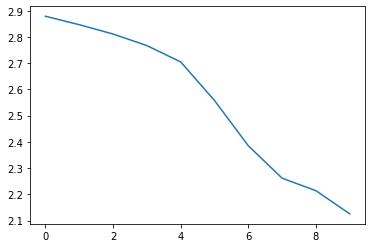

In [21]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

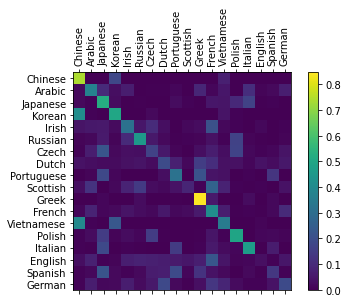

In [22]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [23]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.57) Polish
(-2.15) Czech
(-2.31) Russian

> Jackson
(-1.95) Russian
(-2.02) Scottish
(-2.12) Irish

> Satoshi
(-1.66) Italian
(-1.80) Polish
(-1.87) Japanese

> Alberto
(-1.59) Portuguese
(-1.79) Spanish
(-2.21) Japanese


### So now lets shift to using the RNN Module from Pytorch ###

In [24]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

category = Irish / line = Macshuibhne
category = Irish / line = Coghlan
category = English / line = Panesar
category = Portuguese / line = Serafim
category = Italian / line = Trapani
category = Arabic / line = Naifeh
category = Spanish / line = Alvarado
category = Japanese / line = Anami
category = Arabic / line = Shalhoub
category = Italian / line = Orsini


In [25]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [26]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [31]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.1992 Legrand / French ✓
10000 10% (0m 12s) 1.8467 Hayden / Irish ✓
15000 15% (0m 18s) 1.1196 Antwerpen / Dutch ✓
20000 20% (0m 24s) 0.6146 Aswad / Arabic ✓
25000 25% (0m 30s) 3.3755 Deschamps / Greek ✗ (French)
30000 30% (0m 36s) 0.0628 Calogerakis / Greek ✓
35000 35% (0m 42s) 1.3229 Schoorel / Dutch ✓
40000 40% (0m 47s) 0.5198 Confortola / Italian ✓
45000 45% (0m 53s) 0.0501 Anderson / Scottish ✓
50000 50% (0m 59s) 0.8479 Yudkovich / Russian ✓
55000 55% (1m 5s) 0.2497 Gomatos / Greek ✓
60000 60% (1m 11s) 2.3927 Cantu / French ✗ (Italian)
65000 65% (1m 17s) 1.0575 Spicka / Polish ✗ (Czech)
70000 70% (1m 23s) 0.7737 O'Rourke / Irish ✓
75000 75% (1m 29s) 0.0489 Thai / Vietnamese ✓
80000 80% (1m 35s) 1.6812 Hase / Japanese ✗ (German)
85000 85% (1m 41s) 0.2588 Ortega / Spanish ✓
90000 90% (1m 47s) 0.1116 Okuma / Japanese ✓
95000 95% (1m 53s) 0.4692 Seif / Arabic ✓
100000 100% (1m 59s) 0.0487 Ribeiro / Portuguese ✓


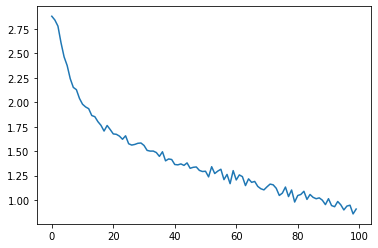

In [32]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [33]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [34]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-0.21) Russian
(-2.46) Czech
(-2.88) English

> Jackson
(-0.16) Scottish
(-2.64) English
(-3.44) Russian

> Satoshi
(-0.39) Japanese
(-1.83) Polish
(-2.49) Italian

> Alberto
(-0.09) Portuguese
(-2.51) Spanish
(-5.10) Italian


## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified